# Code to generate impact oriented warning

## Read and prepare data

In [1]:
# use ICON or COSMO
model = "cosmo1e" # "cosmo1e" "cosmo2e" "icon-ch1-eps" "icon-ch2-eps"

# global parameters
thresh_exp = 0 # minimal threshold (number of buildings) when reading exposure
validation_exp_threshold = 10000 # minimal number of buildings in warning region for being included in validation

In [2]:
#######################
### import packages ###
#######################

import warnings  # To hide the warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import xarray as xr
from shapely import LineString

from climada import CONFIG
from climada.hazard import Hazard
from climada.entity import Exposures

import util_plot as u_plot
import utils 

# define directories
ch_shp_path = f"{CONFIG.local_data.data_dir}/ch_shapefile"
dir_plots = f"{CONFIG.local_data.plot_dir}/hailcast_threshold_warnings"
dir_damage = f"{CONFIG.local_data.data_dir}/damage/"
f_damage = f"{dir_damage}ds_building_dmg_v71_1000m.nc"
# exp_file_path = f"{CONFIG.local_data.data_dir}/Exposures/buildings_CH/exp_buildings_switzerland.h5"
exp_file_path = f"{CONFIG.local_data.data_dir}/Exposures/buildings_CH/exposure_buildings_ch.h5"
dir_poh = f"{CONFIG.local_data.data_dir}/radar_hail/POH/"
if model in ["cosmo1e", "cosmo2e"]:
    dir_cosmo = f"{CONFIG.local_data.data_dir}/HailCast/forecast/{model}/max_66UTC/"
else:
    dir_cosmo = f"{CONFIG.local_data.data_dir}/HailCast/forecast/{model}/reforecast/max_66UTC/"


In [3]:
###################
#### load data ####
###################

# read warning shapefile
warning_shape=gpd.read_file(f"{ch_shp_path}/warning_regions/Warningregions.shp")
warning_shape.crs = ccrs.epsg(21781)
warning_shape = warning_shape[["REGION_NAM", "geometry"]]
warning_shape = warning_shape.to_crs(epsg=2056)


# create date list exluding days with no available forecasts
date_list = pd.concat([
    pd.Series(index=pd.date_range("2021-04-01", "2021-09-30", freq='D')),
    pd.Series(index=pd.date_range("2022-04-01", "2022-09-30", freq='D')),
    pd.Series(index=pd.date_range("2023-04-01", "2023-09-30", freq='D')),
]).index
date_list = date_list.drop(
    ['2022-06-04', '2022-06-05', '2022-06-07', '2022-06-16', '2022-06-17', '2022-06-22', '2022-06-23',
     '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-07', '2022-07-09', '2023-04-01'])
n_days = len(date_list)

# read exposure and impact
exp, exp_2D, imp, imp_coord = utils.load_exposure_and_impacts(
    f_damage, 'n_count_exposure', thresh_exp, n_days, date_list
)

# read hazards
if model in ["cosmo1e", "cosmo2e"]:
    n_members = 11 if model=="cosmo1e" else 21
    run = 6 
else:
    n_members = 11 if model=="icon-ch1-eps" else 21
    run="flexible"
dir_hazard = f"hailcast_{model}_2021_2023.h5"

if Path.cwd().joinpath(dir_hazard).exists():
    haz = Hazard.from_hdf5(dir_hazard)
    haz.event_name = haz.event_id
else:
    haz = utils.load_and_preprocess_hazard(dir_cosmo, run, date_list)
    haz.write_hdf5(dir_hazard)
# process hazard
exp.assign_centroids(haz, threshold=100)
haz_coord = haz.centroids.coord[exp.gdf.centr_HL, :]
haz_data = haz.intensity[:, exp.gdf.centr_HL].toarray()
# assert consistent coordinates for exposure and hazard
np.testing.assert_array_almost_equal(np.array([exp.latitude, exp.longitude]).T,
                                        haz_coord, decimal=2)
np.testing.assert_array_almost_equal(np.array([exp.latitude, exp.longitude]).T,
                                        imp_coord, decimal=2)
# check first dimension of hazard before continuing
if haz_data.shape[0]/n_members != n_days:
    print(haz_data.shape[0]/n_members, n_days)
    sys.exit('Exiting script. Either number of member is wrong, or not all time steps were loaded.')
# check second dimension of hazard before continuing
if haz_data.shape[1] != exp.gdf.shape[0]:
    sys.exit('Exiting script. Something went wrong with subsetting of centroids.')

# read radar data for evaluation
exp_poh = exp.copy()
poh_paths = [f"{dir_poh}BZC_X1d66_{year}.nc" 
             for year in ["2021", "2022", "2023"]]
ds_poh = xr.open_mfdataset(poh_paths, concat_dim='time', combine='nested', coords='minimal')

haz_poh = utils.hazard_from_radar(ds_poh, varname='POH', time_dim='time', spatial_dims=['chx','chy'])
exp_poh.assign_centroids(haz_poh, threshold=100)
poh_coord = haz_poh.centroids.coord[exp_poh.gdf.centr_HL, :]
poh_data = haz_poh.intensity[:, exp_poh.gdf.centr_HL].toarray() 

# choose warning regions for validation
regions_above_threshold = utils.warning_regions_above_exp_threshold(validation_exp_threshold, warning_shape, exp)
warning_shape_validate = warning_shape.loc[warning_shape["REGION_NAM"].isin(regions_above_threshold)]


Centroids before subsetting: 33366
Centroids after subsetting:   9170
2025-11-13 14:16:47,043 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-11-13 14:16:47,044 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-11-13 14:16:47,044 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-11-13 14:16:47,045 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity thre

In [4]:
########################################
#### prepare observed impact objects ###
########################################

thresh_imp=0
imp_boolean = (imp>thresh_imp)

# create impact gdfs
gdf_imp_boolean = gpd.GeoDataFrame({
    **{str(date)[:10]: imp_boolean[i] for i, date in enumerate(date_list)},
    "geometry":  exp.gdf.geometry
}).reset_index(drop=True)
gdf_imp = gpd.GeoDataFrame({
    **{str(date)[:10]: imp[i] for i, date in enumerate(date_list)},
    "geometry":  exp.gdf.geometry
}).reset_index(drop=True)
gdf_exp = gpd.GeoDataFrame({
    "exposure": np.squeeze(exp_2D[0]),
    "geometry":  exp.gdf.geometry
}).reset_index(drop=True)

imp_observed_warningregions = utils.sum_gdf_to_regions(warning_shape_validate, gdf_imp)
imp_observed_warningregions_bool = utils.df_to_boolean(imp_observed_warningregions)

exp_warningregions = utils.sum_gdf_to_regions(warning_shape_validate, gdf_exp)

## Create warning map examples

In [5]:
##########################
### create warning gdf ###
##########################

# get hazard intensity at exposure centroids
exp_CH = Exposures.from_hdf5(exp_file_path) # BFS exposure layer (all of Switzerland)
exp_CH.assign_centroids(haz, threshold=100)
haz_coord_CH = haz.centroids.coord[exp_CH.gdf.centr_HL, :]
haz_data_CH = haz.intensity[:, exp_CH.gdf.centr_HL].toarray()

thresh_agree_CH = 0.3 # agreement threshold
threshs_haz_CH = [10,20,30] # hail size threshold
# thresh_agree_CH = 0.05 # agreement threshold
# threshs_haz_CH = [10,15,20] # hail size threshold
warning_CH = np.zeros((int(haz_data_CH.shape[0]/n_members), haz_data_CH.shape[1]))
for thresh_haz_CH in threshs_haz_CH:
    haz_exceed_CH = haz_data_CH>thresh_haz_CH
    haz_exceed_freq_CH = np.add.reduceat(haz_exceed_CH, range(0,haz_data_CH.shape[0],n_members))/n_members
    warning_CH += (haz_exceed_freq_CH>thresh_agree_CH).astype(float)

gdf_warning_CH = gpd.GeoDataFrame({
    **{str(date)[:10]: warning_CH[i] for i, date in enumerate(date_list)},
    "geometry":  exp_CH.gdf.geometry
}).reset_index(drop=True)


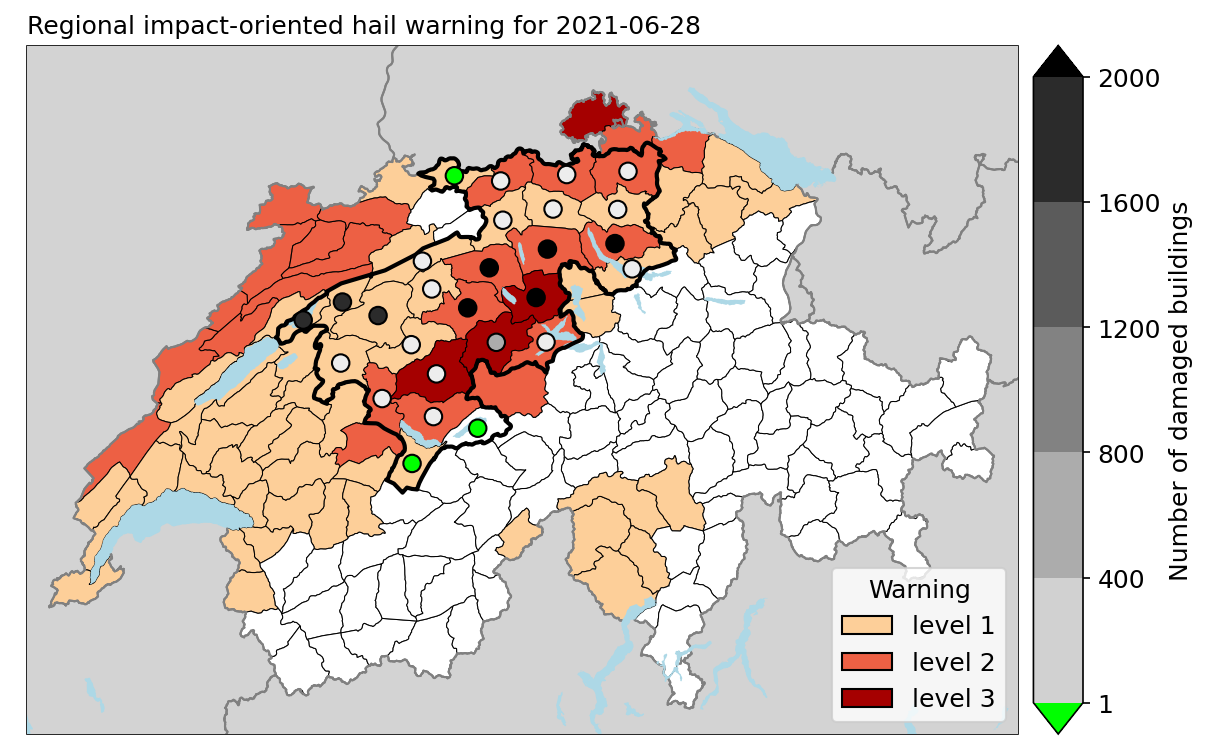

In [11]:
##########################
### plot warning map #####
##########################

flex_colors = False # set to True if colorbar of observed impact should be chosen depending on range

example_date = "2021-06-28"
# example_date = "2021-07-12"
gdf_regions_warnings_CH = utils.max_gdf_to_regions(warning_shape, gdf_warning_CH)
# create emtpy plot for cantonal impacts
fig, ax, cbax = u_plot.create_empty_plot_CH(f"Regional impact-oriented hail warning for {example_date}", figsize=(8,5),
                                              show_cantons=False, four_cantons=False, four_cantons_style="dashed")
cbax.set_visible(True)
ax.set_xlim(*u_plot.CH_extent_x)
ax.set_ylim(*u_plot.CH_extent_y)

# fill map
map_projection = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
warning_map = utils.create_warning_map_from_gdf(gdf_regions_warnings_CH, warning_shape, example_date)
cmap_warning = u_plot.get_cmap_killian(name="OrRd")
cmap_warning.set_under("white")
warning_map.to_crs(map_projection).plot(ax=ax, column="value", cmap=cmap_warning, vmin=.5, vmax=3, edgecolor="black", linewidth=.5)

# include observed impact in validation regions
warning_map["observed_impacts"] = np.NaN
warning_map = warning_map.set_index("REGION_NAM")
for region in imp_observed_warningregions[example_date].index:
    warning_map.loc[region, "observed_impacts"] = imp_observed_warningregions.loc[region, example_date]
warning_map["centroids"] = warning_map.geometry.centroid
warning_map.set_geometry("centroids", inplace=True)
cmap = u_plot.get_cmap_killian(name="Greys",levels=np.linspace(0., 1., 7))
cmap.set_under("#00FF00")
if flex_colors: 
    warning_map.to_crs(map_projection).plot(ax=ax, cmap=cmap, column="observed_impacts", zorder=10, edgecolor="black", vmin=1, s=70)
else:
    warning_map.to_crs(map_projection).plot(ax=ax, cmap=cmap, column="observed_impacts", zorder=10, edgecolor="black", vmin=1, vmax=2000, s=70)

# include solid exteriorexterior
warning_map.set_geometry("geometry", inplace=True)
exterior_eval = warning_map.to_crs(map_projection).loc[~np.isnan(warning_map["observed_impacts"])].unary_union.exterior
ax.add_geometries(LineString(exterior_eval), crs=map_projection, facecolor='none', edgecolor='black', linewidth=2, zorder=9)

# add colorbar
if flex_colors:
    bounds = np.linspace(1,imp_observed_warningregions[example_date].max(), cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="min")
else:
    bounds = np.concatenate([np.array([1]), np.linspace(400, 2000, 5)])
    norm = mpl.colors.BoundaryNorm(bounds, 8, extend="both")
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbax, orientation="vertical"
)
cbar.set_label("Number of damaged buildings")

# Create a Normalize object that maps 0–3 to the colormap
norm = mpl.colors.Normalize(vmin=0.5, vmax=3)
# Get the colors corresponding to the 4 discrete integer values
colors = [cmap_warning(norm(i)) for i in range(4)]
# Create legend patches for each category
legend_elements = [
    # mpl.patches.Patch(facecolor=colors[0], edgecolor='black', label='0'),
    mpl.patches.Patch(facecolor=colors[1], edgecolor='black', label='level 1'),
    mpl.patches.Patch(facecolor=colors[2], edgecolor='black', label='level 2'),
    mpl.patches.Patch(facecolor=colors[3], edgecolor='black', label='level 3')
]

# Add the custom legend
ax.legend(handles=legend_elements, title="Warning", loc='lower right')

# plt.savefig(f"{dir_plots}/warningmaps/warningmap_{model}_date{example_date}_{thresh_agree_CH}_{thresh_haz_CH}_with_validation_threshval{validation_exp_threshold}.png", bbox_inches='tight')

## Evaluation of warnings

In [7]:
################################
### generate skill metrics #####
################################

# set thresholds for evaluation plot
thresh_haz_list = np.linspace(10, 40, 31, endpoint=True) 
thresh_agree_list = [0.05, 0.23]
# thresh_haz_list = np.linspace(5, 35, 31, endpoint=True) 
# thresh_agree_list = [0.05, 0.23]

# prepare POH data for comparison 
gdf_poh = gpd.GeoDataFrame(
    data=poh_data.T,
    geometry=exp_poh.geometry,
    columns=[str(date)[:10] for date in ds_poh.coords["time"].values],
)
# restrict to forecasted dates
gdf_cols = [str(date)[:10] for date in date_list]
gdf_cols.append("geometry")
gdf_poh = gdf_poh[gdf_cols]
# set poh threshold and compute boolean gdf
poh_thresh = 80
gdf_poh_boolean = gdf_poh.copy()
gdf_poh_boolean[gdf_poh_boolean.columns[:-1]] = (gdf_poh_boolean[gdf_poh_boolean.columns[:-1]] > poh_thresh)
# aggregate to warning regions
poh_warningregions = utils.sum_gdf_to_regions(warning_shape_validate, gdf_poh_boolean)
poh_warningregions_bool = utils.df_to_boolean(poh_warningregions)

# compute skills of warning wrt observed impacts
skills_dict, skills_poh = {}, {}
for thresh_haz in thresh_haz_list: 
    for thresh_agree in thresh_agree_list: 
        # compute warning
        haz_exceed = haz_data>thresh_haz
        haz_exceed_freq = np.add.reduceat(haz_exceed, range(0,haz_data.shape[0],n_members))/n_members
        warning_boolean = haz_exceed_freq>thresh_agree
        del haz_exceed

        # create warning gdf
        gdf_warning_boolean = gpd.GeoDataFrame({
            **{str(date)[:10]: warning_boolean[i] for i, date in enumerate(date_list)},
            "geometry":  exp.gdf.geometry
        }).reset_index(drop=True)

        # group by region
        warnings_warningregions = utils.sum_gdf_to_regions(warning_shape_validate, gdf_warning_boolean)
        warnings_warningregions_boolean = utils.df_to_boolean(warnings_warningregions)
        
        # compute skills of warning wrt obserbed impact
        skills_dict[(thresh_haz, thresh_agree)] = utils.compute_boolean_skill_scores_per_region(
            imp_observed_warningregions_bool, warnings_warningregions_boolean
        )

        # compute skills of warning wrt POH 
        skills_poh[(thresh_haz, thresh_agree)] = utils.compute_boolean_skill_scores_per_region(
            poh_warningregions_bool, warnings_warningregions_boolean
        )

        # POD and FAR on building level
        skills_dict[(thresh_haz, thresh_agree)]["POD_weighted"] = utils.POD_weighted(
            imp_observed_warningregions, warnings_warningregions_boolean
        )
        skills_dict[(thresh_haz, thresh_agree)]["FAR_weighted"] = utils.FAR_weighted(
            imp_observed_warningregions, warnings_warningregions_boolean, exp_warningregions
        )

# compute skills of POH wrt observed impact
skill_radar_damage = utils.compute_boolean_skill_scores_per_region(
            imp_observed_warningregions_bool,
            poh_warningregions_bool
        )

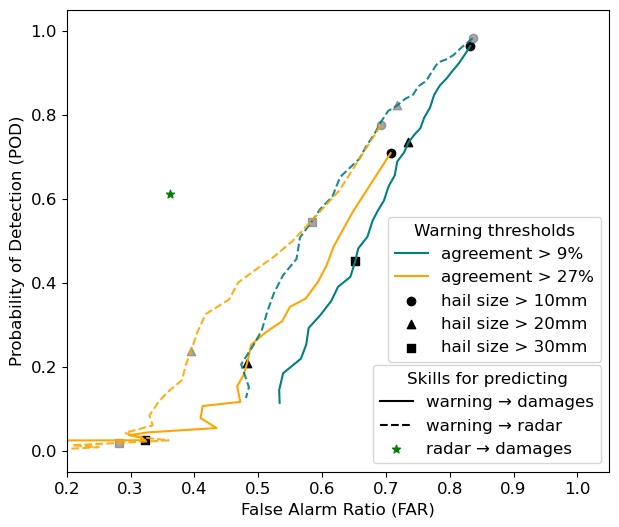

In [18]:
##########################
### plot POD and FAR #####
##########################

# plot comparison POD to FAR
include_POH = True
include_POH_impact_point = True

col1, col2 = "teal", "Orange"
fig, ax = plt.subplots(1,1,figsize=(7,6))
hail_size_points = [10.,20.,30.]
# hail_size_points = [10.,15.,20.]

handles_legend1, handles_legend2 = [], []
for thresh_agree, label_agree, color in zip(
    thresh_agree_list,
    ["agreement > 9%", "agreement > 27%"],
    [col1, col2]
):
    handles_legend1.append(ax.plot(
        [skills_dict[(thresh_haz,thresh_agree)]["FAR_regions"].mean().values[0] for thresh_haz in thresh_haz_list],
        [skills_dict[(thresh_haz,thresh_agree)]["POD_regions"].mean().values[0] for thresh_haz in thresh_haz_list], linewidth=1.5,
        label=label_agree, color=color
    )[0])

for thresh_haz, label, marker in zip(hail_size_points, [f"hail size > {int(size)}mm" for size in hail_size_points], ["o", "^", "s"]):
    handles_legend1.append(ax.scatter(
        [skills_dict[(thresh_haz,thresh_agree)]["FAR_regions"].mean().values[0] for thresh_agree in thresh_agree_list],
        [skills_dict[(thresh_haz,thresh_agree)]["POD_regions"].mean().values[0] for thresh_agree in thresh_agree_list],
        label=label, marker=marker, color="black"))
    if include_POH:
        ax.scatter(
            [skills_poh[(thresh_haz,thresh_agree)]["FAR_regions"].mean().values[0] for thresh_agree in thresh_agree_list],
            [skills_poh[(thresh_haz,thresh_agree)]["POD_regions"].mean().values[0] for thresh_agree in thresh_agree_list],
            marker=marker, color="grey", alpha = .7)

if include_POH:
    for thresh_agree, label_agree, color in zip(thresh_agree_list, ["at least 1 member", "at least 3 members"], [col1, col2]):
        handles_legend2.append(ax.plot(
            [skills_poh[(thresh_haz,thresh_agree)]["FAR_regions"].mean().values[0] for thresh_haz in thresh_haz_list],
            [skills_poh[(thresh_haz,thresh_agree)]["POD_regions"].mean().values[0] for thresh_haz in thresh_haz_list], linewidth=1.5,
            label="warning vs radar", linestyle = 'dashed', color=color, alpha = .9,
        )[0])

if include_POH_impact_point:
    handles_legend2.append(ax.scatter(skill_radar_damage["FAR"], skill_radar_damage["POD"], marker="*", color="g", label="radar → damages"))

# ax.legend(title="Thresholds", )
# two legends
legend1 = ax.legend(handles=handles_legend1, title="Warning thresholds", loc='lower right', bbox_to_anchor=(1.0, 0.22))
ax.add_artist(legend1)  # Add it manually so we can make another one

# # Second legend (Title 2)
custom_handles = [
    mpl.lines.Line2D([], [], color='k', lw=1.5, label='warning → damages'),
    mpl.lines.Line2D([], [], linestyle="dashed", color='k', lw=1.5, label='warning → radar'),
    handles_legend2[-1]
]
ax.legend(handles=custom_handles, title="Skills for predicting", loc='lower right')

ax.set_xlabel("False Alarm Ratio (FAR)")
ax.set_ylabel("Probability of Detection (POD)")
ax.set_xlim([.2,1.05])
ax.set_ylim([-.05,1.05]);

# plt.savefig(f'{dir_plots}/POH_comparison/HR_FAR_curve_{model}_region-exp-thresh{validation_exp_threshold}_all.png')

In [10]:
######################################
### compute weighted FAR AND POD #####
######################################

test_thresh_haz = 20.
test_thresh_agree = 0.23
print("Skills per warning region:\nPOD: "
      f'{skills_dict[(test_thresh_haz, test_thresh_agree)]["POD"]}'
      "\nFAR: "
      f'{skills_dict[(test_thresh_haz, test_thresh_agree)]["FAR"]}'
)
print("Skills per building:\nPOD: "
      f'{skills_dict[(test_thresh_haz, test_thresh_agree)]["POD_weighted"]}'
      "\nFAR: "
      f'{skills_dict[(test_thresh_haz, test_thresh_agree)]["FAR_weighted"]}'
)

Skills per warning region:
POD: 0.19477124183006536
FAR: 0.4716312056737589
Skills per building:
POD: 0.6164689409850334
FAR: 0.9963701669861335
